### Reinforcement Learning Project 
### Q-Learning with different Variations
#### 10 X 10 Maze Environment



In [1]:
import gym
import maze_env
import numpy as np
import matplotlib.pyplot as plt

##### Initializing the Maze Environment

In [2]:
env = maze_env.MazeEnvRandom10x10(enable_render=False)
NUM_ACTIONS = env.action_space.n  
print("Number of actions: ", NUM_ACTIONS)
STATE_BOUNDS = list(zip(env.observation_space.low, env.observation_space.high))
print("State Bounds:",STATE_BOUNDS)
print("Observation Space: ", env.observation_space)
print("Maze Size: ", env.maze_size)
print("Initial State: ", env.state)

MAZE_SIZE = tuple((env.observation_space.high + np.ones(env.observation_space.shape)).astype(int))
NUM_BUCKETS = MAZE_SIZE 
print("Number of buckets: ", NUM_BUCKETS)

Number of actions:  4
State Bounds: [(0, 9), (0, 9)]
Observation Space:  Box(0, 9, (2,), int64)
Maze Size:  (10, 10)
Initial State:  [0. 0.]
Number of buckets:  (10, 10)


Environment:
- The agent may only choose to go up, down, right, or left ("N", "S", "E", "W"). If the way is blocked, it will remain at the same the location.
- The observation space is the (x, y) coordinate of the agent. The top left cell is (0, 0).
- A reward of 1 is given when the agent reaches the goal. For every step in the maze, the agent recieves a reward of -0.1/(number of cells).
- The maze is reset when the agent reaches the goal.

## Baseline Q-Learning

Episode 0 finished after 726 steps with total reward = 0.27499999999999947.
Episode 1 finished after 2409 steps with total reward = -1.4079999999998458.
Episode 2 finished after 2038 steps with total reward = -1.0369999999998867.
Episode 3 finished after 1220 steps with total reward = -0.21899999999997655.
Episode 4 finished after 1504 steps with total reward = -0.5029999999999453.
Episode 5 finished after 1130 steps with total reward = -0.12899999999998646.
Episode 6 finished after 520 steps with total reward = 0.48099999999999965.
Episode 7 finished after 1273 steps with total reward = -0.2719999999999707.
Episode 8 finished after 715 steps with total reward = 0.2859999999999995.
Episode 9 finished after 1268 steps with total reward = -0.26699999999997126.
Episode 10 finished after 593 steps with total reward = 0.4079999999999996.
Episode 11 finished after 629 steps with total reward = 0.37199999999999955.
Episode 12 finished after 804 steps with total reward = 0.1969999999999994.
Ep

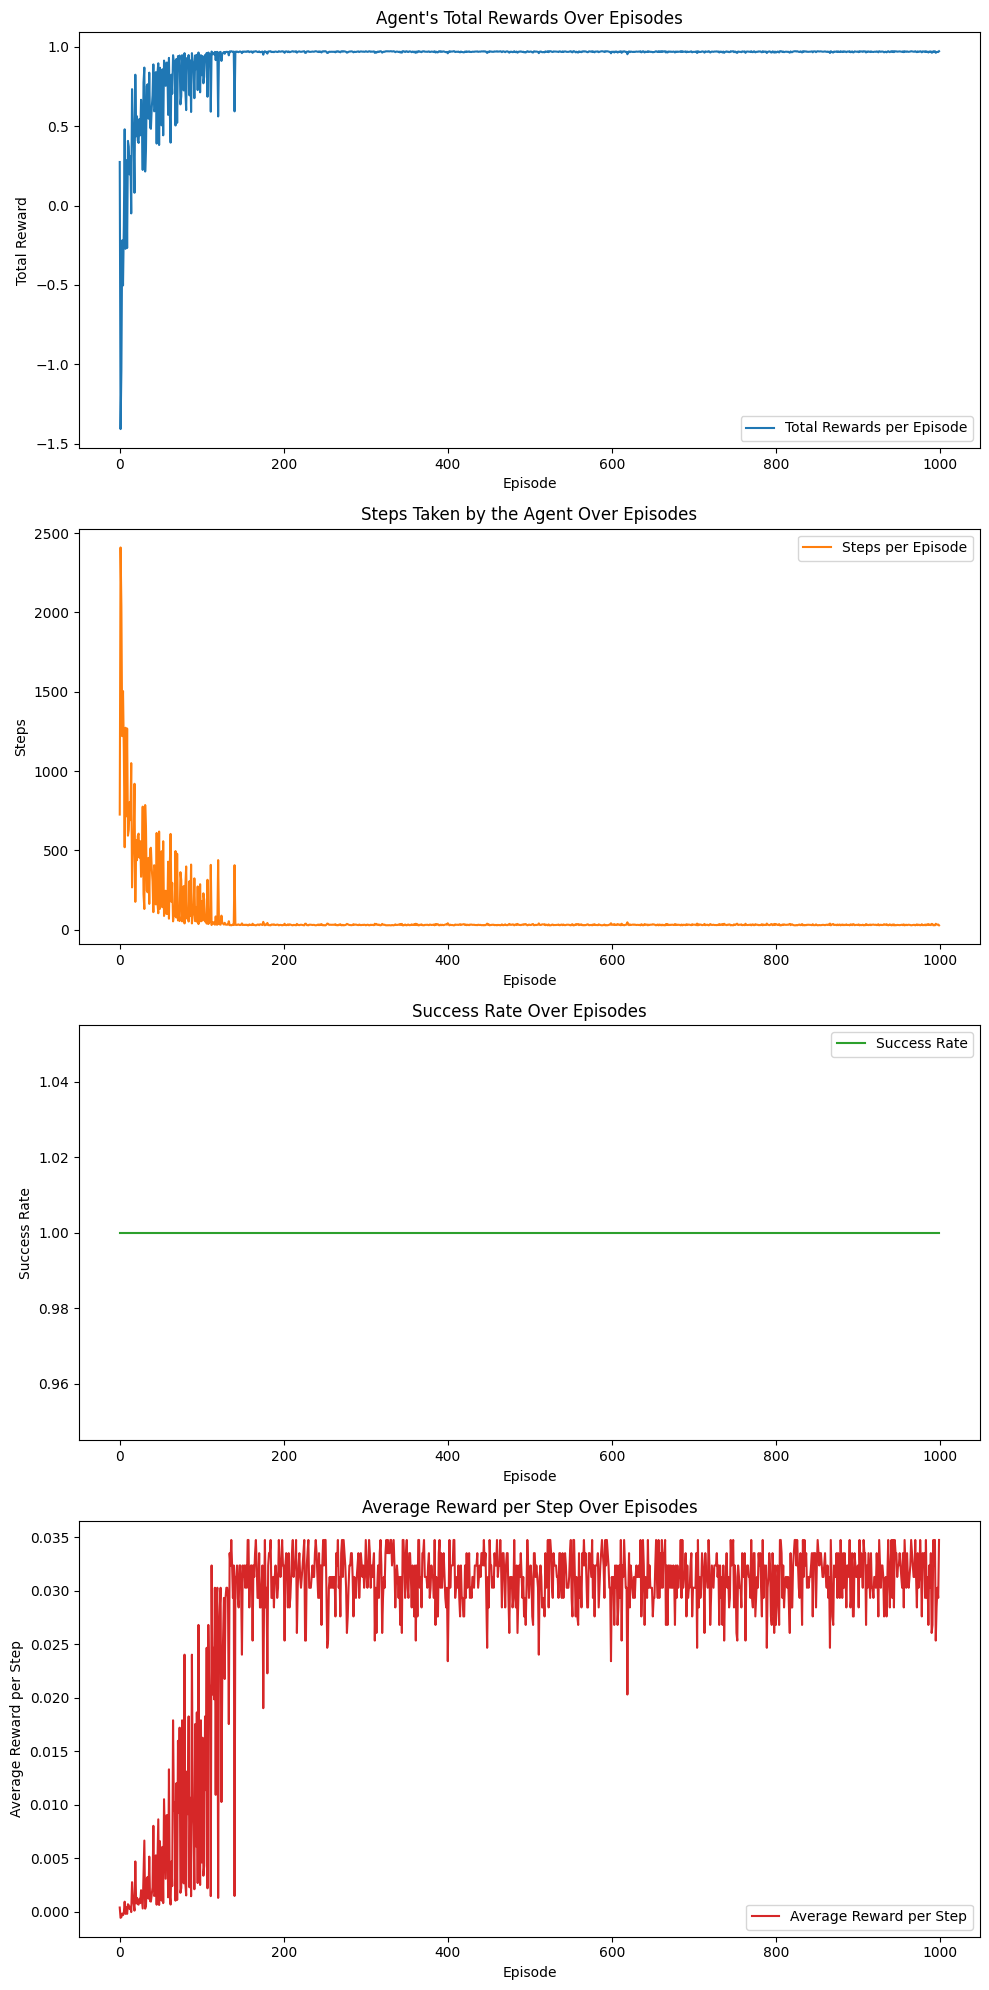

Overall success rate: 1.00
Average ΔQ per step: 0.0965


In [3]:
ACTION_MAPPING = {0: "N", 1: "E", 2: "S", 3: "W"}

class QLearning_Agent:
    def __init__(self, action_space_size, state_space_shape, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.q_table = np.zeros(state_space_shape + (action_space_size,))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.action_space_size = action_space_size

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.randint(0, self.action_space_size)
        else:
            action = np.argmax(self.q_table[state])
        return action

    def learn(self, state, action, reward, next_state):
        predict = self.q_table[state + (action,)]
        target = reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state + (action,)] += self.alpha * (target - predict)

def run_episode(agent, env, episode):
    state = env.reset()
    state = (int(state[0]), int(state[1]))
    action = agent.choose_action(state)
    total_reward = 0
    steps = 0
    success = False
    delta_q = 0
    visitation_counts = np.zeros((10, 10))  # Local count for this episode

    while True:
        visitation_counts[state] += 1  # Increment visitation count for the current state
        action_dir = ACTION_MAPPING[action]
        next_state, reward, done, _ = env.step(action_dir)
        next_state = (int(next_state[0]), int(next_state[1]))
        next_action = agent.choose_action(next_state)
        
        # Capture the change in Q-value for convergence check
        q_value_before = agent.q_table[state + (action,)]
        agent.learn(state, action, reward, next_state)
        q_value_after = agent.q_table[state + (action,)]
        delta_q += np.abs(q_value_after - q_value_before)

        state = next_state
        action = next_action
        total_reward += reward
        steps += 1

        if done:
            success = (reward == 1)  
            print(f"Episode {episode} finished after {steps} steps with total reward = {total_reward}.")
            break

    return total_reward, steps, success, delta_q, visitation_counts

def simulate():
    env = maze_env.MazeEnvRandom10x10(enable_render=False)
    agent = QLearning_Agent(action_space_size=env.action_space.n, state_space_shape=(10, 10))
    
    NUM_EPISODES = 1000
    total_rewards = []
    steps_per_episode = []
    successes = []
    delta_qs = []
    visitation_counts_all = np.zeros((10, 10))

    for episode in range(NUM_EPISODES):
        total_reward, steps, success, delta_q, visitation_counts = run_episode(agent, env, episode)
        total_rewards.append(total_reward)
        steps_per_episode.append(steps)
        successes.append(success)
        delta_qs.append(delta_q)
        visitation_counts_all += visitation_counts

    success_rate = np.mean(successes)
    average_reward_per_step = [r / s if s != 0 else 0 for r, s in zip(total_rewards, steps_per_episode)]
    average_delta_q = np.mean(delta_qs)

    # Plotting the results
    fig, axs = plt.subplots(3, 1, figsize=(10, 20))

    axs[0].plot(total_rewards, label='Total Rewards per Episode')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Total Reward')
    axs[0].set_title('Agent\'s Total Rewards Over Episodes')
    axs[0].legend()

    axs[1].plot(steps_per_episode, label='Steps per Episode', color='tab:orange')
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Steps')
    axs[1].set_title('Steps Taken by the Agent Over Episodes')
    axs[1].legend()

    axs[2].plot(average_reward_per_step, label='Average Reward per Step', color='tab:red')
    axs[2].set_xlabel('Episode')
    axs[2].set_ylabel('Average Reward per Step')
    axs[2].set_title('Average Reward per Step Over Episodes')
    axs[2].legend()

    plt.tight_layout()
    plt.show()

    print(f"Overall success rate: {success_rate:.2f}")
    print(f"Average ΔQ per step: {average_delta_q:.4f}")

if __name__ == "__main__":
    simulate()

-	**Total Rewards Over Episodes:** The agent exhibits a steady increase to a plateau in total rewards, suggesting it's consistently achieving higher rewards as it learns.
-	**Steps Taken by the Agent Over Episodes:** A sharp decrease and then a flat trend in the number of steps per episode imply that the agent becomes more efficient at finding the goal with minimal moves quickly.
-	**Average Reward per Step Over Episodes:** There's a rising trend in average reward per step, although with some variability, indicating the agent's growing proficiency per action taken in the maze.


## Variation 1 - Adaptive Learning Rate

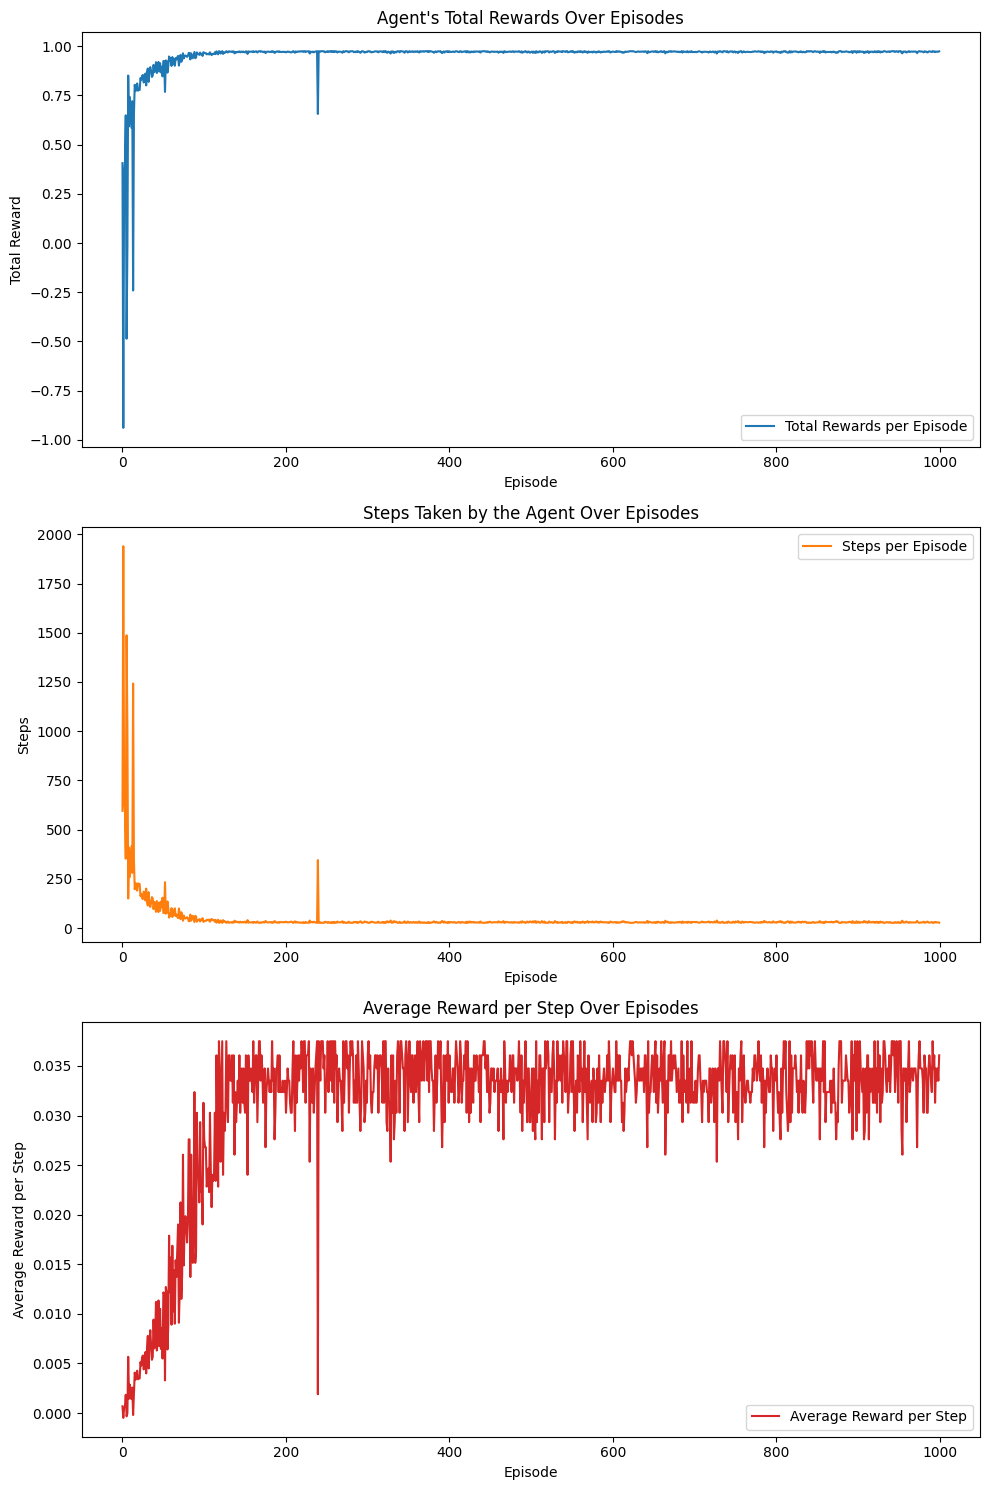

Overall success rate: 1.00


In [7]:
ACTION_MAPPING = {0: "N", 1: "E", 2: "S", 3: "W"}

class QLearning_Agent_AdaptiveLR:
    def __init__(self, action_space_size, state_space_shape, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.q_table = np.zeros(state_space_shape + (action_space_size,))
        self.initial_alpha = alpha  # Starting learning rate
        self.alpha = alpha  # Learning rate that will adapt
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.action_space_size = action_space_size

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.action_space_size)
        return np.argmax(self.q_table[state])

    def learn(self, state, action, reward, next_state):
        predict = self.q_table[state + (action,)]
        target = reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state + (action,)] += self.alpha * (target - predict)

    def update_learning_rate(self, episode, min_alpha=0.01, decay_rate=0.001):
        self.alpha = max(min_alpha, self.initial_alpha * np.exp(-decay_rate * episode))

def run_episode(agent, env, episode):
    state = env.reset()
    state = (int(state[0]), int(state[1]))
    total_reward = 0
    steps = 0
    success = False

    while True:
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(ACTION_MAPPING[action])
        next_state = (int(next_state[0]), int(next_state[1]))
        
        agent.learn(state, action, reward, next_state)
        
        state = next_state
        total_reward += reward
        steps += 1

        if done:
            success = reward == 1
            break

    return total_reward, steps, success

def simulate(env, num_episodes=1000, alpha=0.1, gamma=0.99, epsilon=0.1, decay_rate=0.001):
    agent = QLearning_Agent_AdaptiveLR(env.action_space.n, (10, 10), alpha, gamma, epsilon)
    
    rewards, steps, successes = [], [], []
    for episode in range(num_episodes):
        agent.update_learning_rate(episode, decay_rate=decay_rate)
        total_reward, step, success = run_episode(agent, env, episode)
        rewards.append(total_reward)
        steps.append(step)
        successes.append(success)

    success_rate = np.mean(successes)
    average_reward_per_step = [r / s if s != 0 else 0 for r, s in zip(rewards, steps)]
    
    # Plotting the results
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))

    axs[0].plot(rewards, label='Total Rewards per Episode')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Total Reward')
    axs[0].set_title('Agent\'s Total Rewards Over Episodes')
    axs[0].legend()

    axs[1].plot(steps, label='Steps per Episode', color='tab:orange')
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Steps')
    axs[1].set_title('Steps Taken by the Agent Over Episodes')
    axs[1].legend()

    axs[2].plot(average_reward_per_step, label='Average Reward per Step', color='tab:red')
    axs[2].set_xlabel('Episode')
    axs[2].set_ylabel('Average Reward per Step')
    axs[2].set_title('Average Reward per Step Over Episodes')
    axs[2].legend()

    plt.tight_layout()
    plt.show()

    print(f"Overall success rate: {success_rate:.2f}")

if __name__ == "__main__":
    env = maze_env.MazeEnvRandom10x10(enable_render=False)  # Ensure correct environment setup
    simulate(env)


-	**Total Rewards Over Episodes:** The agent's cumulative reward quickly plateaus, indicating a rapid acquisition of a successful strategy for navigating the maze.
-	**Steps Taken by the Agent Over Episodes:** An initial sharp decrease in steps taken, which then stabilizes, reflects the agent’s efficiency in finding the goal with fewer moves over time.
-	**Average Reward per Step Over Episodes:** The average reward per step increases sharply at first before displaying some variance while maintaining a broadly consistent value, which is typical of Q-Learning agents as they continue to refine their policy through exploration.


## Variation 2 - Epsilon Decay

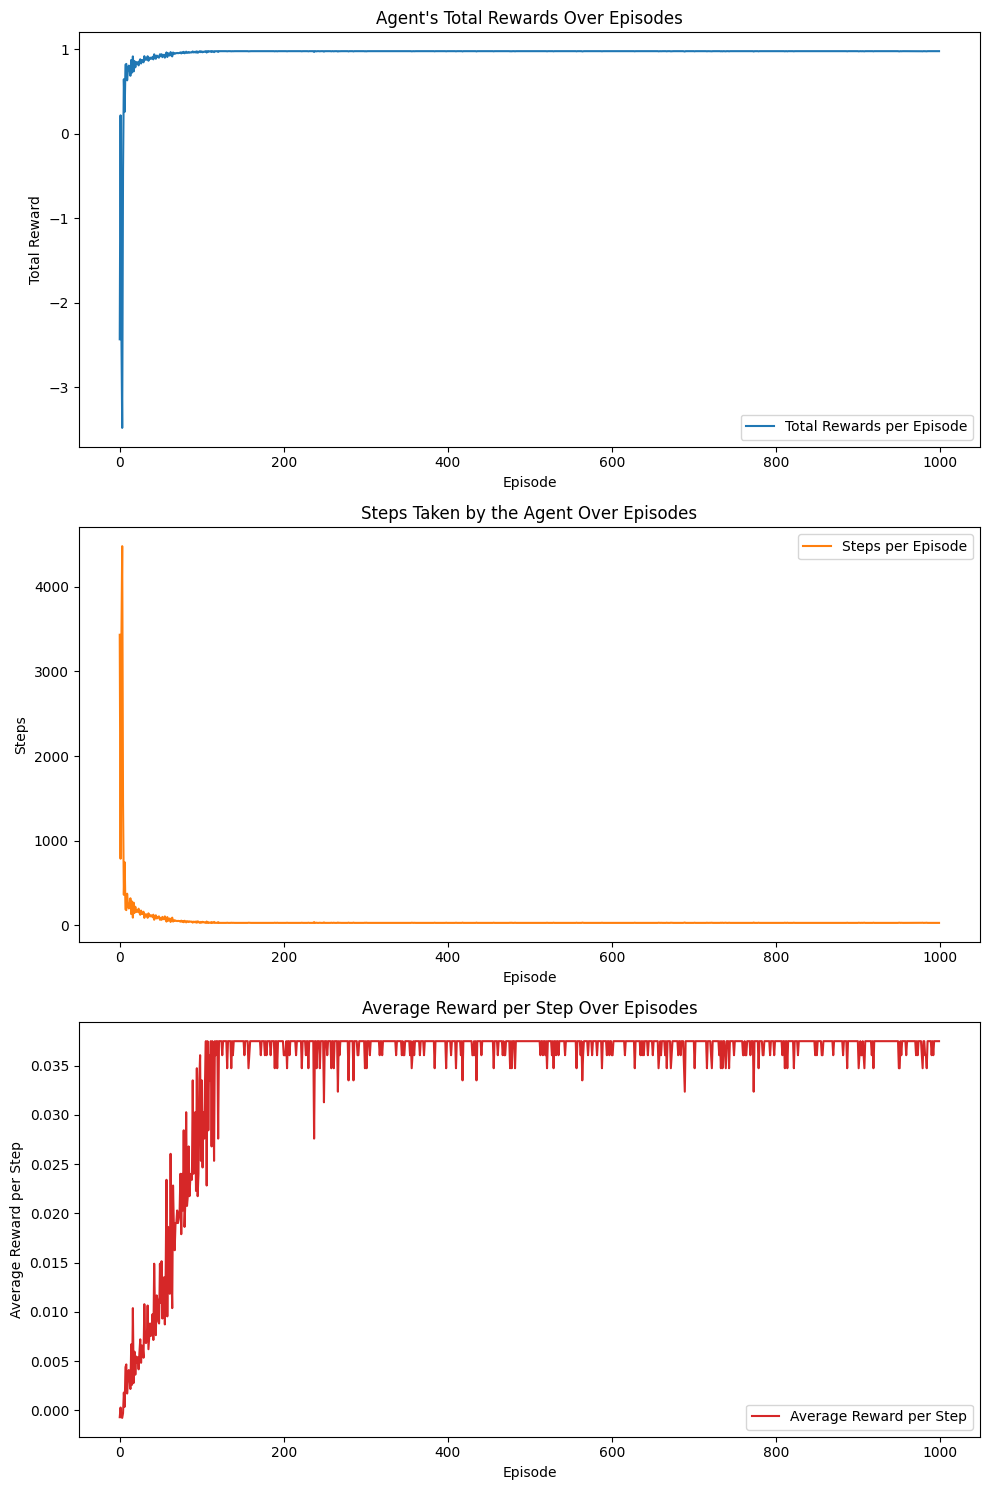

Overall success rate: 1.00


In [8]:
ACTION_MAPPING = {0: "N", 1: "E", 2: "S", 3: "W"}

class QLearning_Agent_EpsilonDecay:
    def __init__(self, action_space_size, state_space_shape, alpha=0.1, gamma=0.99, initial_epsilon=1.0, min_epsilon=0.01, decay_rate=0.001):
        self.q_table = np.zeros(state_space_shape + (action_space_size,))
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = initial_epsilon  # Initial exploration rate
        self.min_epsilon = min_epsilon  # Minimum exploration rate
        self.decay_rate = decay_rate  # Rate at which epsilon decays
        self.action_space_size = action_space_size

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.randint(0, self.action_space_size)
        else:
            action = np.argmax(self.q_table[state])
        return action

    def learn(self, state, action, reward, next_state):
        predict = self.q_table[state + (action,)]
        target = reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state + (action,)] += self.alpha * (target - predict)

    def update_exploration_rate(self, episode):
        self.epsilon = max(self.min_epsilon, self.epsilon * np.exp(-self.decay_rate * episode))

def run_episode(agent, env):
    state = env.reset()
    state = (int(state[0]), int(state[1]))
    total_reward, steps = 0, 0
    success = False

    while True:
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(ACTION_MAPPING[action])
        next_state = (int(next_state[0]), int(next_state[1]))
        
        agent.learn(state, action, reward, next_state)
        
        state = next_state
        total_reward += reward
        steps += 1

        if done:
            success = (reward == 1)
            break

    return total_reward, steps, success

def simulate(env, num_episodes=1000):
    agent = QLearning_Agent_EpsilonDecay(env.action_space.n, (10, 10), alpha=0.1, gamma=0.99, initial_epsilon=1.0, min_epsilon=0.01, decay_rate=0.01)
    
    rewards, steps, successes = [], [], []
    for episode in range(num_episodes):
        agent.update_exploration_rate(episode)
        total_reward, step, success = run_episode(agent, env)
        rewards.append(total_reward)
        steps.append(step)
        successes.append(success)
    
    success_rate = np.mean(successes)
    average_reward_per_step = [r / s if s != 0 else 0 for r, s in zip(rewards, steps)]

    # Plotting the results
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))

    axs[0].plot(rewards, label='Total Rewards per Episode')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Total Reward')
    axs[0].set_title('Agent\'s Total Rewards Over Episodes')
    axs[0].legend()

    axs[1].plot(steps, label='Steps per Episode', color='tab:orange')
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Steps')
    axs[1].set_title('Steps Taken by the Agent Over Episodes')
    axs[1].legend()

    axs[2].plot(average_reward_per_step, label='Average Reward per Step', color='tab:red')
    axs[2].set_xlabel('Episode')
    axs[2].set_ylabel('Average Reward per Step')
    axs[2].set_title('Average Reward per Step Over Episodes')
    axs[2].legend()

    plt.tight_layout()
    plt.show()

    print(f"Overall success rate: {success_rate:.2f}")

if __name__ == "__main__":
    simulate(env)

-	**Total Rewards Over Episodes:** The agent's rewards rapidly level off after the initial phase, which indicates a quick learning of effective strategies in the maze environment.
-	**Steps Taken by the Agent Over Episodes:** The number of steps plummets initially and then steadies, implying the agent is finding shorter paths to the goal more consistently as it learns.
-	**Average Reward per Step Over Episodes:** The upward trend followed by stabilization in the average reward per step suggests the agent's increased efficiency in navigating the maze.


## Variation 3 - Discount Factor Changes

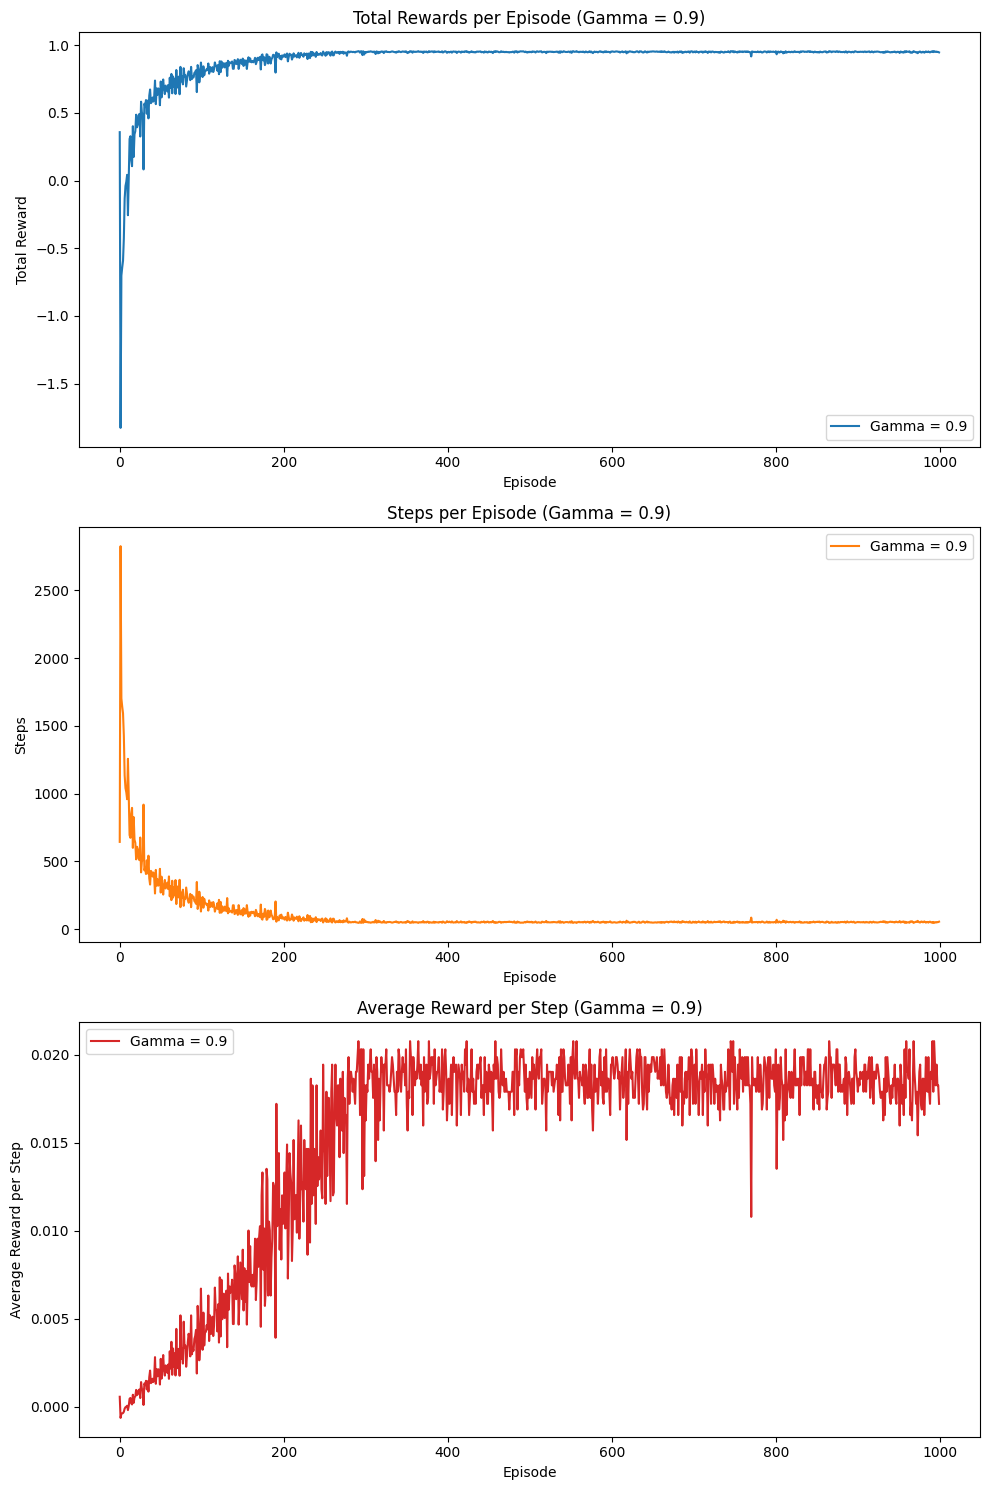

Gamma: 0.9, Success Rate: 1.00


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import maze_env  
ACTION_MAPPING = {0: "N", 1: "E", 2: "S", 3: "W"}

class QLearning_Agent:
    def __init__(self, action_space_size, state_space_shape, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.q_table = np.zeros(state_space_shape + (action_space_size,))
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.action_space_size = action_space_size

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.action_space_size)
        return np.argmax(self.q_table[state])

    def learn(self, state, action, reward, next_state):
        predict = self.q_table[state + (action,)]
        target = reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state + (action,)] += self.alpha * (target - predict)

def run_episode(agent, env):
    state = env.reset()
    state = (int(state[0]), int(state[1]))
    total_reward, steps = 0, 0
    success = False

    while True:
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(ACTION_MAPPING[action])
        next_state = (int(next_state[0]), int(next_state[1]))
        
        agent.learn(state, action, reward, next_state)
        state = next_state
        total_reward += reward
        steps += 1

        if done:
            success = reward == 1 

    return total_reward, steps, success

def simulate_different_gammas(env, num_episodes=1000):
    gamma_values = [0.9]
    results = {}

    for gamma in gamma_values:
        agent = QLearning_Agent(env.action_space.n, (10, 10), alpha=0.1, gamma=gamma, epsilon=0.1)
        rewards, steps_list, successes = [], [], []
        
        for episode in range(num_episodes):
            total_reward, steps, success = run_episode(agent, env)
            rewards.append(total_reward)
            steps_list.append(steps)
            successes.append(success)

        success_rate = np.mean(successes)
        average_reward_per_step = [r / s if s > 0 else 0 for r, s in zip(rewards, steps_list)]
        results[gamma] = {
            'rewards': rewards,
            'steps': steps_list,
            'success_rate': success_rate,
            'average_reward_per_step': average_reward_per_step
        }

        # Plotting the results for each gamma
        fig, axs = plt.subplots(3, 1, figsize=(10, 15))
        axs[0].plot(results[gamma]['rewards'], label=f'Gamma = {gamma}')
        axs[0].set_title(f'Total Rewards per Episode (Gamma = {gamma})')
        axs[0].set_xlabel('Episode')
        axs[0].set_ylabel('Total Reward')
        axs[0].legend()

        axs[1].plot(results[gamma]['steps'], label=f'Gamma = {gamma}', color = 'tab:orange')
        axs[1].set_title(f'Steps per Episode (Gamma = {gamma})')
        axs[1].set_xlabel('Episode')
        axs[1].set_ylabel('Steps')
        axs[1].legend()

        axs[2].plot(results[gamma]['average_reward_per_step'], label=f'Gamma = {gamma}', color = 'tab:red')
        axs[2].set_title(f'Average Reward per Step (Gamma = {gamma})')
        axs[2].set_xlabel('Episode')
        axs[2].set_ylabel('Average Reward per Step')
        axs[2].legend()

        plt.tight_layout()
        plt.show()

        print(f"Gamma: {gamma}, Success Rate: {results[gamma]['success_rate']:.2f}")

if __name__ == "__main__":
    env = maze_env.MazeEnvRandom10x10(enable_render=False)  # Ensure correct environment setup
    simulate_different_gammas(env)


-	**Total Rewards per Episode:** The rewards increase sharply and then plateau, indicating the agent is quick to find a policy that yields steady returns as it interacts with the maze.
-	**Steps per Episode:** The drastic reduction in steps and subsequent leveling off signal that the agent is learning to reach the goal more efficiently, with fewer missteps as it progresses through the episodes.
-	**Average Reward per Step:** This metric climbs initially and then fluctuates around a stable value, suggesting that while the agent is becoming more proficient at navigating the maze, there's room for optimization, possibly by fine-tuning the balance between exploration and exploitation.
